In [ ]:
# Install necessary libraries
!pip install transformers torch matplotlib seaborn nltk


In [ ]:
!pip uninstall torch -y

In [ ]:
!pip install torch torchvision torchaudio


In [ ]:
!pip install transformers

In [ ]:
import torch
print(f'PyTorch version: {torch.__version__}')

from transformers import pipeline
print("Transformers library is working!")

PyTorch version: 2.4.1+cu121
Transformers library is working!


In [ ]:
# Import libraries
from transformers import pipeline
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Upload your script
import pandas as pd

# List of movie titles and corresponding filenames for the scripts
movies = [
    {'title': 'Snow White', 'filename': 'Snow White.txt'},
    {'title': 'Cinderella', 'filename': 'Cinderella.txt'},
    {'title': 'Sleeping Beauty', 'filename': 'Sleeping Beauty.txt'},
    {'title': 'The Little Mermaid', 'filename': 'The Little Mermaid.txt'},
    {'title': 'Beauty and the Beast', 'filename': 'Beauty and the Beast.txt'},
    {'title': 'Aladdin', 'filename': 'Aladdin.txt'},
    {'title': 'Pocahontas', 'filename': 'Pocahontas.txt'},
    {'title': 'Mulan', 'filename': 'Mulan.txt'},
    {'title': 'Princess and the Frog', 'filename': 'Princess and the Frog.txt'},
    {'title': 'Tangled', 'filename': 'Tangled.txt'},
    {'title': 'Brave', 'filename': 'Brave.txt'},
    {'title': 'Frozen', 'filename': 'Frozen.txt'},
    {'title': 'Wreck It Ralph', 'filename': 'Wreck It Ralph.txt'}
]

In [ ]:
# Load the movie script
def read_script(filename):
    with open(filename, 'r') as file:
        script = file.read()
    return script

In [ ]:
# Initialize the zero-shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Define the feminism labels
feminism_labels = ["Feminine gender stereotypes", "Reinforcement of patriarchal ideals", "Feminist attitudes and behaviour"]

In [ ]:
# Function to chunk text into manageable size for classification
def chunk_text(sentences, max_length=512):
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        current_length += len(sentence)
        current_chunk.append(sentence)
        # If chunk length exceeds max_length, append it and reset
        if current_length >= max_length:
            chunks.append(" ".join(current_chunk))
            current_chunk = []
            current_length = 0

            # Add the last chunk if there's remaining text
    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

In [ ]:
# Function to classify the script and aggregate scores for each label
def classify_script(script, labels):  # Add 'labels' as a second argument
    # Tokenize the script into sentences
    sentences = sent_tokenize(script)

    # Split the script into chunks for classification (BERT-like models usually limit to 512 tokens)
    chunks = chunk_text(sentences, max_length=512)

    # Initialize cumulative scores for each label
    cumulative_scores = {label: 0 for label in labels}

    # Calculate the total number of chunks
    total_chunks = len(chunks)

    # Classify each chunk and accumulate the scores
    for chunk in chunks:
        result = classifier(chunk, candidate_labels=labels)
        for i, label in enumerate(result['labels']):
            cumulative_scores[label] += result['scores'][i]

    # Average the scores across chunks
    if total_chunks > 0:  # To avoid division by zero
        avg_scores = {label: cumulative_scores[label] / total_chunks for label in labels}
    else:
        avg_scores = {label: 0 for label in labels}  # Handle edge case for empty scripts

    return avg_scores  # Return the aggregated average scores


In [ ]:
# Initialize an empty DataFrame to store results
df_results = pd.DataFrame(columns=['title', 'feminism'])

In [ ]:
# Function to read the script from the file with encoding handling
def read_script(filename):
    try:
        # Try reading the file with utf-8 encoding
        with open(filename, 'r', encoding='utf-8') as file:
            return file.read()
    except UnicodeDecodeError:
        # If utf-8 fails, try ISO-8859-1 or Windows-1252 encoding
        with open(filename, 'r', encoding='ISO-8859-1') as file:
            return file.read()

# Initialize an empty DataFrame to store results
df_results = pd.DataFrame(columns=['title', 'feminism'])

# Loop through each movie
for movie in movies:
    title = movie['title']
    filename = movie['filename']

    # Read the script from the file
    script = read_script(filename)

    # Get the confidence scores from the analysis
    scores = classify_script(script, feminism_labels)  # Pass feminism_labels as an argument

    # Create a string representation of feminism for the current movie
    feminism_str = ', '.join([f"{label}: {scores[label]:.2f}" for label in feminism_labels])

    # Create a DataFrame with the current movie's results
    new_row = pd.DataFrame({
        'title': [title],
        'feminism': [feminism_str]
    })

    # Concatenate the new row with the existing dataframe
    df_results = pd.concat([df_results, new_row], ignore_index=True)

# Display the dataframe with classification scores for all movies
print(df_results)


                    title                                           feminism
0              Snow White  Feminine gender stereotypes: 0.27, Reinforceme...
1              Cinderella  Feminine gender stereotypes: 0.27, Reinforceme...
2         Sleeping Beauty  Feminine gender stereotypes: 0.28, Reinforceme...
3      The Little Mermaid  Feminine gender stereotypes: 0.29, Reinforceme...
4    Beauty and the Beast  Feminine gender stereotypes: 0.23, Reinforceme...
5                 Aladdin  Feminine gender stereotypes: 0.20, Reinforceme...
6              Pocahontas  Feminine gender stereotypes: 0.19, Reinforceme...
7                   Mulan  Feminine gender stereotypes: 0.30, Reinforceme...
8   Princess and the Frog  Feminine gender stereotypes: 0.22, Reinforceme...
9                 Tangled  Feminine gender stereotypes: 0.29, Reinforceme...
10                  Brave  Feminine gender stereotypes: 0.29, Reinforceme...
11                 Frozen  Feminine gender stereotypes: 0.25, Reinforceme...

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


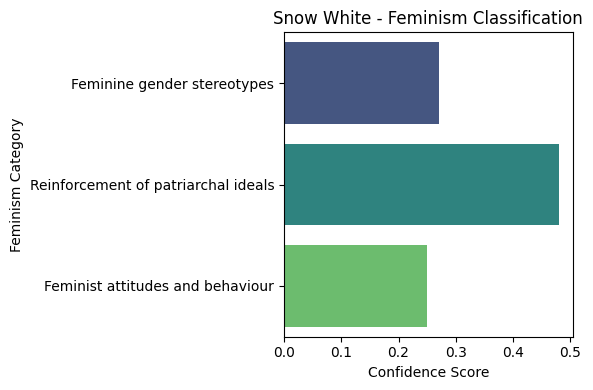

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


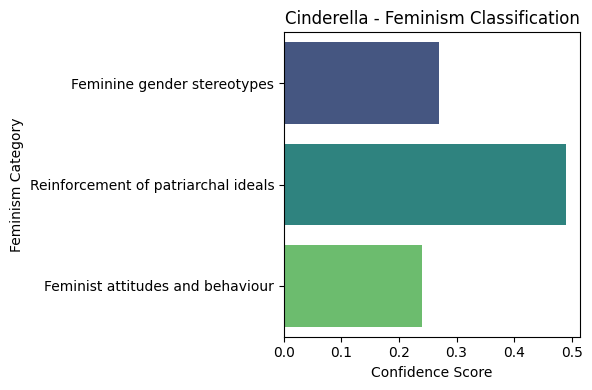

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


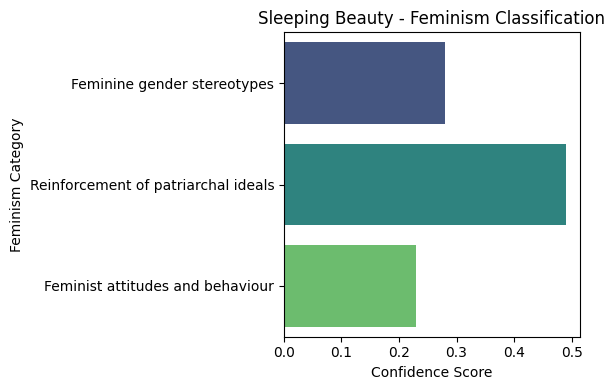

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


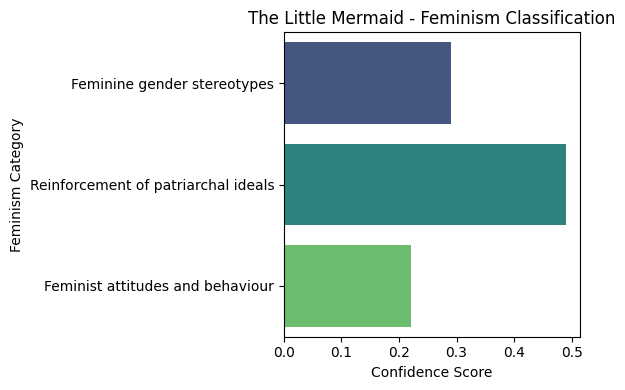

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


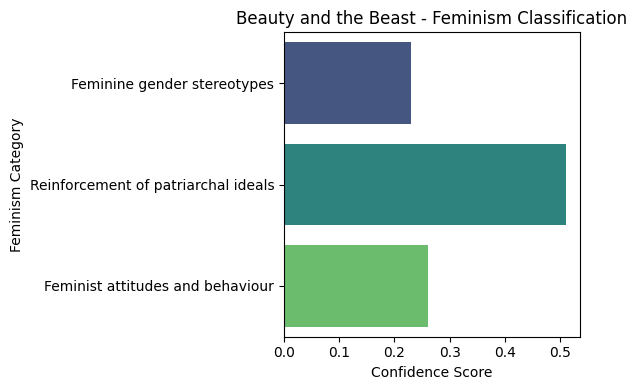

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


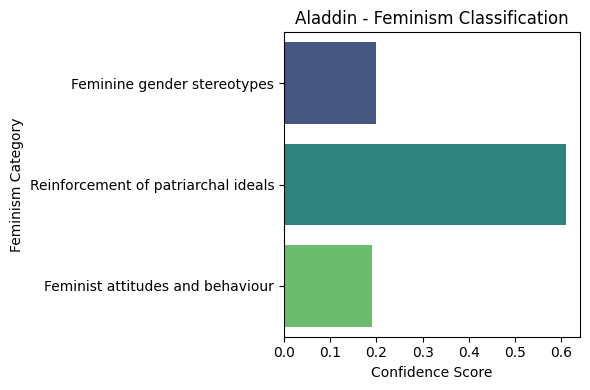

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


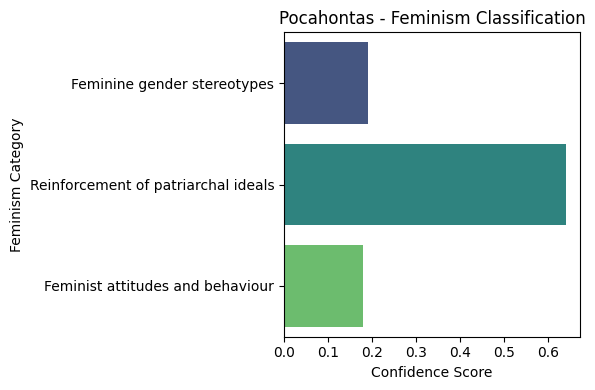

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


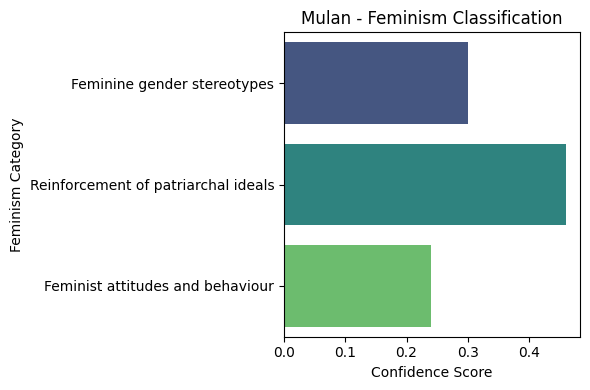

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


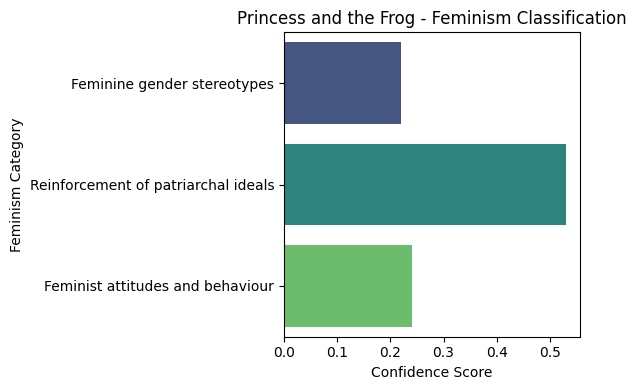

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


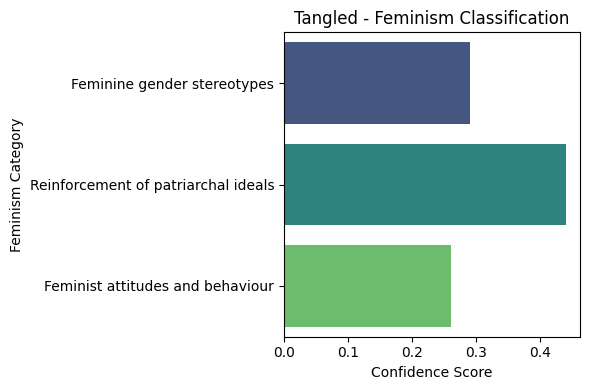

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


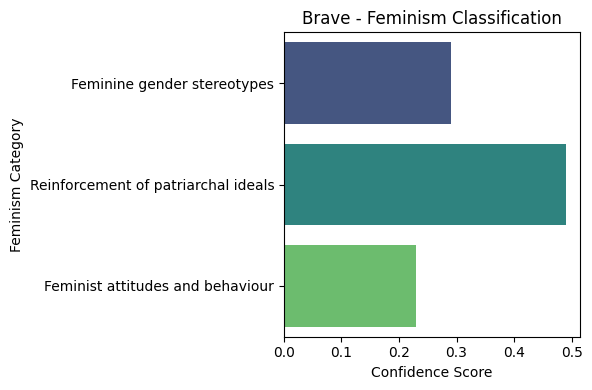

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


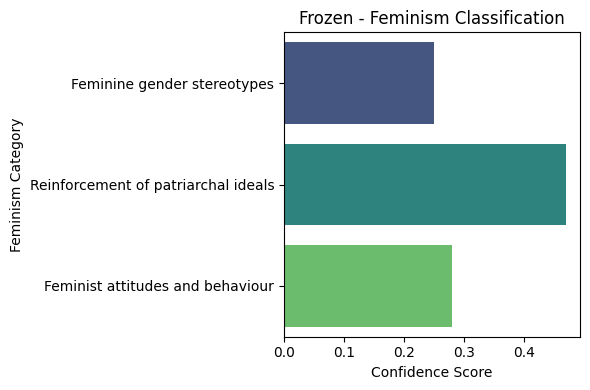

<ipython-input-13-396ce21b01ba>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars


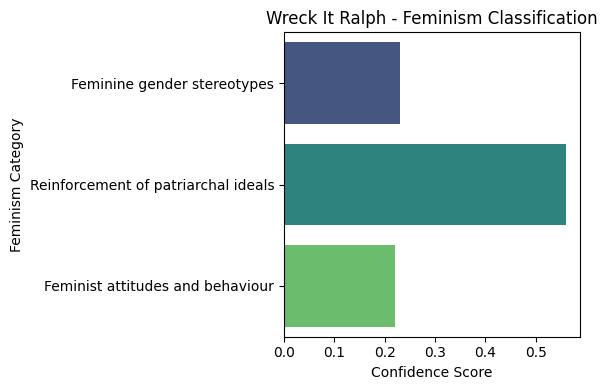

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Split the 'feminism' column into separate columns
df_split = df_results['feminism'].str.extract(r'Feminine gender stereotypes: (\d+\.\d+), Reinforcement of patriarchal ideals: (\d+\.\d+), Feminist attitudes and behaviour: (\d+\.\d+)')
df_split.columns = ['Feminine gender stereotypes', 'Reinforcement of patriarchal ideals', 'Feminist attitudes and behaviour']

# Convert the columns to numeric types (float) to allow plotting
df_split = df_split.astype(float)

# Merge the split columns back to the original dataframe
df_results = pd.concat([df_results, df_split], axis=1)

# Step 2: Visualization of classification scores for each movie
def visualize_classification_results_for_all_movies(df_results):
    # Loop through the dataframe (each row represents a movie)
    for i, row in df_results.iterrows():
        # Extract the movie title and classification scores
        movie_title = row['title']
        scores = [row['Feminine gender stereotypes'], row['Reinforcement of patriarchal ideals'], row['Feminist attitudes and behaviour']]

        # Modify the labels for the bar chart
        labels = ['Feminine gender stereotypes', 'Reinforcement of patriarchal ideals', 'Feminist attitudes and behaviour']

        # Create a horizontal barplot for each movie
        plt.figure(figsize=(6, 4))
        sns.barplot(x=scores, y=labels, palette='viridis')  # Swap x and y for horizontal bars

        # Set titles and labels
        plt.title(f'{movie_title} - Feminism Classification')
        plt.xlabel('Confidence Score')  # X-axis now represents the confidence scores
        plt.ylabel('Feminism Category')

        # Show the plot
        plt.tight_layout()
        plt.show()

# Call the function to visualize
visualize_classification_results_for_all_movies(df_results)


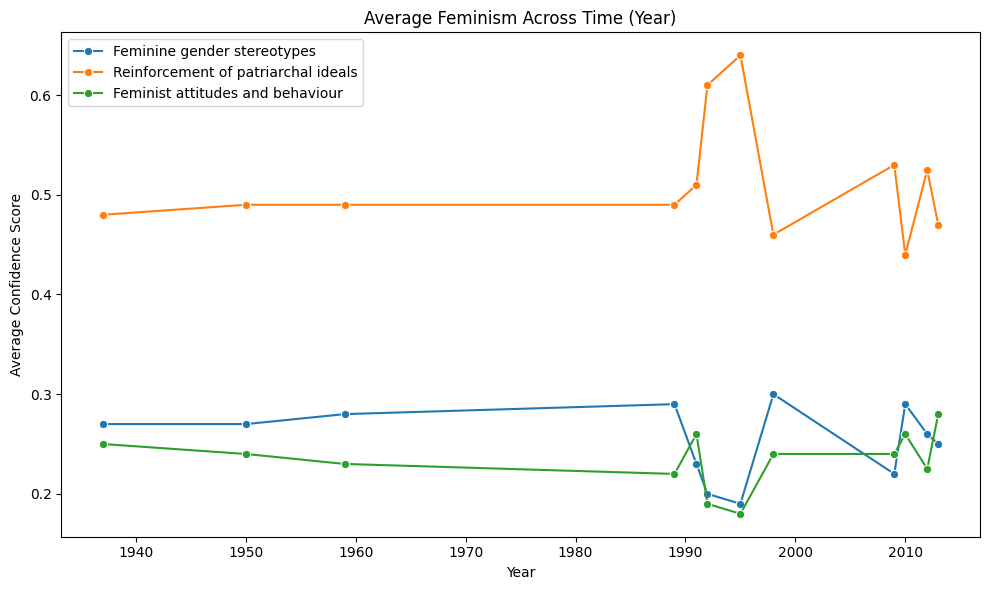

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a DataFrame mapping movies to periods and years (example with extracted years)
movies_periods_years = [
    {'title': 'Snow White', 'period': 'Classics', 'year': 1937},
    {'title': 'Cinderella', 'period': 'Classics', 'year': 1950},
    {'title': 'Sleeping Beauty', 'period': 'Classics', 'year': 1959},
    {'title': 'The Little Mermaid', 'period': 'Renaissance', 'year': 1989},
    {'title': 'Beauty and the Beast', 'period': 'Renaissance', 'year': 1991},
    {'title': 'Aladdin', 'period': 'Renaissance', 'year': 1992},
    {'title': 'Princess and the Frog', 'period': 'Renaissance', 'year': 2009},
    {'title': 'Pocahontas', 'period': 'Renaissance', 'year': 1995},
    {'title': 'Mulan', 'period': 'Renaissance', 'year': 1998},
    {'title': 'Tangled', 'period': 'New Age', 'year': 2010},
    {'title': 'Brave', 'period': 'New Age', 'year': 2012},
    {'title': 'Frozen', 'period': 'New Age', 'year': 2013},
    {'title': 'Wreck It Ralph', 'period': 'New Age', 'year': 2012}
]

# Step 2: Create the dataframe
df_movies_periods = pd.DataFrame(movies_periods_years)

# Assuming you have df_results already containing a column 'title'
# Map the period and year information to the df_results DataFrame
df_results['period'] = df_results['title'].map(df_movies_periods.set_index('title')['period'])
df_results['year'] = df_results['title'].map(df_movies_periods.set_index('title')['year'])

# Step 3: Aggregate feminism by year
df_aggregate_by_year = df_results.groupby('year')[['Feminine gender stereotypes', 'Reinforcement of patriarchal ideals', 'Feminist attitudes and behaviour']].mean().reset_index()

# Step 4: Visualization of feminism values across time (year)
def visualize_feminism_across_time(df_aggregate_by_year):
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot the feminism values across years
    sns.lineplot(data=df_aggregate_by_year, x='year', y='Feminine gender stereotypes', label='Feminine gender stereotypes', marker='o')
    sns.lineplot(data=df_aggregate_by_year, x='year', y='Reinforcement of patriarchal ideals', label='Reinforcement of patriarchal ideals', marker='o')
    sns.lineplot(data=df_aggregate_by_year, x='year', y='Feminist attitudes and behaviour', label='Feminist attitudes and behaviour', marker='o')

    # Add titles and labels
    plt.title('Average Feminism Across Time (Year)')
    plt.xlabel('Year')
    plt.ylabel('Average Confidence Score')

    # Show the plot
    plt.tight_layout()
    plt.legend()
    plt.show()

# Call the function to visualize
visualize_feminism_across_time(df_aggregate_by_year)


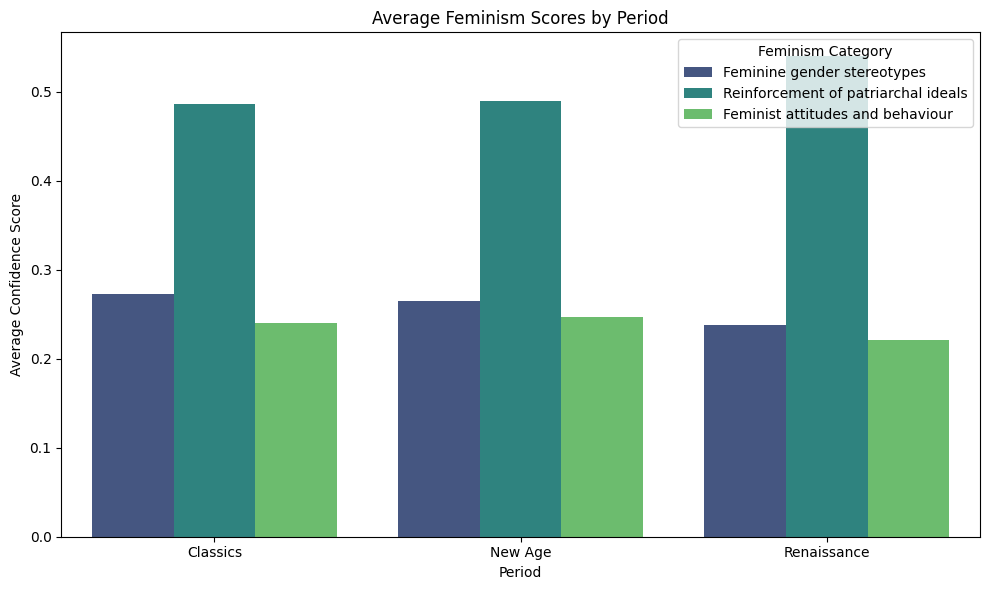

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a DataFrame mapping movies to periods and years (already done)
movies_periods_years = {
      'Snow White': {'period': 'Classics', 'year': 1937},
    'Cinderella': {'period': 'Classics', 'year': 1950},
    'Sleeping Beauty': {'period': 'Classics', 'year': 1959},
    'The Little Mermaid': {'period': 'Renaissance', 'year': 1989},
    'Beauty and the Beast': {'period': 'Renaissance', 'year': 1991},
    'Aladdin': {'period': 'Renaissance', 'year': 1992},
    'Princess and the Frog': {'period': 'Renaissance', 'year': 2009},
    'Pocahontas': {'period': 'Renaissance', 'year': 1995},
    'Mulan': {'period': 'Renaissance', 'year': 1998},
    'Tangled': {'period': 'New Age', 'year': 2010},
    'Brave': {'period': 'New Age', 'year': 2012},
    'Frozen': {'period': 'New Age', 'year': 2013},
    'Wreck It Ralph': {'period': 'New Age', 'year': 2012}
}

# Step 2: Create the dataframe
df_movies_periods = pd.DataFrame(movies_periods_years).T

# Map the period and year information to the df_results DataFrame
df_results['period'] = df_results['title'].map(df_movies_periods['period'])
df_results['year'] = df_results['title'].map(df_movies_periods['year'])

# Step 3: Aggregate feminism scores by period
df_aggregate_by_period = df_results.groupby('period')[['Feminine gender stereotypes', 'Reinforcement of patriarchal ideals', 'Feminist attitudes and behaviour']].mean().reset_index()

# Step 4: Visualization of aggregate confidence scores for each period
def visualize_feminism_by_period(df_aggregate_by_period):
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Create the bar plot for each feminism category
    df_melt = df_aggregate_by_period.melt(id_vars='period', var_name='Feminism Category', value_name='Average Confidence Score')
    sns.barplot(data=df_melt, x='period', y='Average Confidence Score', hue='Feminism Category', palette='viridis')

    # Add titles and labels
    plt.title('Average Feminism Scores by Period')
    plt.xlabel('Period')
    plt.ylabel('Average Confidence Score')

    # Show the plot
    plt.tight_layout()
    plt.legend(title='Feminism Category')
    plt.show()

# Call the function to visualize
visualize_feminism_by_period(df_aggregate_by_period)
